In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset and normalize to (0,1)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 9.91M/9.91M [00:00<00:00, 141MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 23.6MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 51.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.04MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, M):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, M)  # Output dimension is M
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(M, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()  # Output to match input range (0,1)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [ ]:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, _ in train_loader:
            data = data.view(-1, 784).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return train_loss

def test_autoencoder(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)
            output = model(data)
            loss = criterion(output, data)
            test_loss += loss.item() * data.size(0)
    return test_loss / len(test_loader.dataset)


In [ ]:
# Parameters
learning_rate = 0.001
num_epochs = 20
M_values = [2, 5, 10]
train_loss_history = {}
test_loss_history = {}

for M in M_values:
    print(f"\nTraining autoencoder with M = {M}")
    model = Autoencoder(M).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train and test
    train_loss = train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)
    test_loss = test_autoencoder(model, test_loader, criterion)

    train_loss_history[M] = train_loss
    test_loss_history[M] = test_loss



Training autoencoder with M = 2
Epoch [1/20], Loss: 0.9646
Epoch [2/20], Loss: 0.9254
Epoch [3/20], Loss: 0.9254
Epoch [4/20], Loss: 0.9254
Epoch [5/20], Loss: 0.9254
Epoch [6/20], Loss: 0.9254
Epoch [7/20], Loss: 0.9254
Epoch [8/20], Loss: 0.9252
Epoch [9/20], Loss: 0.9231
Epoch [10/20], Loss: 0.9196
Epoch [11/20], Loss: 0.9166
Epoch [12/20], Loss: 0.9139
Epoch [13/20], Loss: 0.9130
Epoch [14/20], Loss: 0.9124
Epoch [15/20], Loss: 0.9119
Epoch [16/20], Loss: 0.9115
Epoch [17/20], Loss: 0.9113
Epoch [18/20], Loss: 0.9110
Epoch [19/20], Loss: 0.9107
Epoch [20/20], Loss: 0.9105

Training autoencoder with M = 5
Epoch [1/20], Loss: 0.9626
Epoch [2/20], Loss: 0.9254
Epoch [3/20], Loss: 0.9244
Epoch [4/20], Loss: 0.9185
Epoch [5/20], Loss: 0.9096
Epoch [6/20], Loss: 0.9055
Epoch [7/20], Loss: 0.9029
Epoch [8/20], Loss: 0.9008
Epoch [9/20], Loss: 0.8989
Epoch [10/20], Loss: 0.8972
Epoch [11/20], Loss: 0.8958
Epoch [12/20], Loss: 0.8946
Epoch [13/20], Loss: 0.8935
Epoch [14/20], Loss: 0.8924


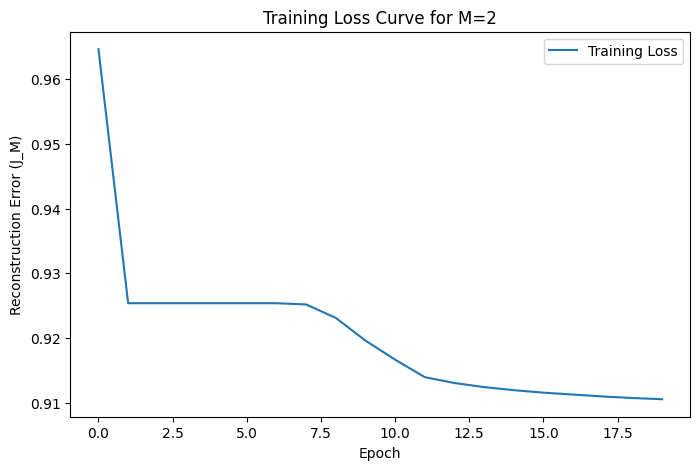

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history[2], label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (J_M)")
plt.title("Training Loss Curve for M=2")
plt.legend()
plt.show()


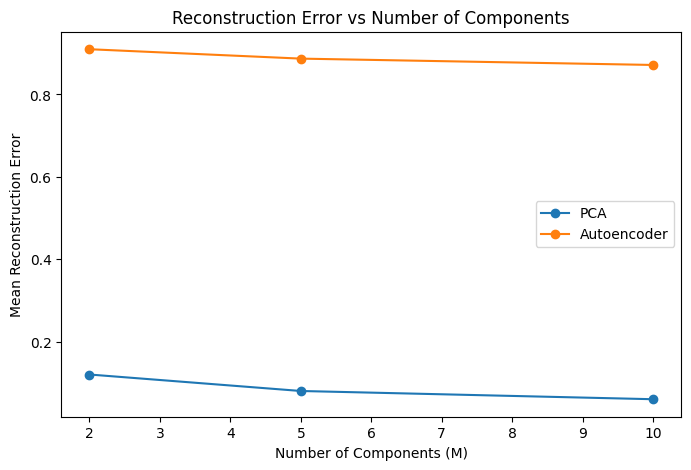

In [ ]:
# Assume `pca_errors` is a list of mean reconstruction errors from the PCA experiment in Problem 1
# Example placeholder PCA errors for M = [2, 5, 10]
pca_errors = [0.12, 0.08, 0.06]  # Ensure this list matches the length of M_values

autoencoder_errors = [test_loss_history[M] for M in M_values]
plt.figure(figsize=(8, 5))
plt.plot(M_values, pca_errors, marker='o', label="PCA")
plt.plot(M_values, autoencoder_errors, marker='o', label="Autoencoder")
plt.xlabel("Number of Components (M)")
plt.ylabel("Mean Reconstruction Error")
plt.title("Reconstruction Error vs Number of Components")
plt.legend()
plt.show()

Encoder output for label 0 does not have two components.
Encoder output for label 1 does not have two components.
Encoder output for label 9 does not have two components.


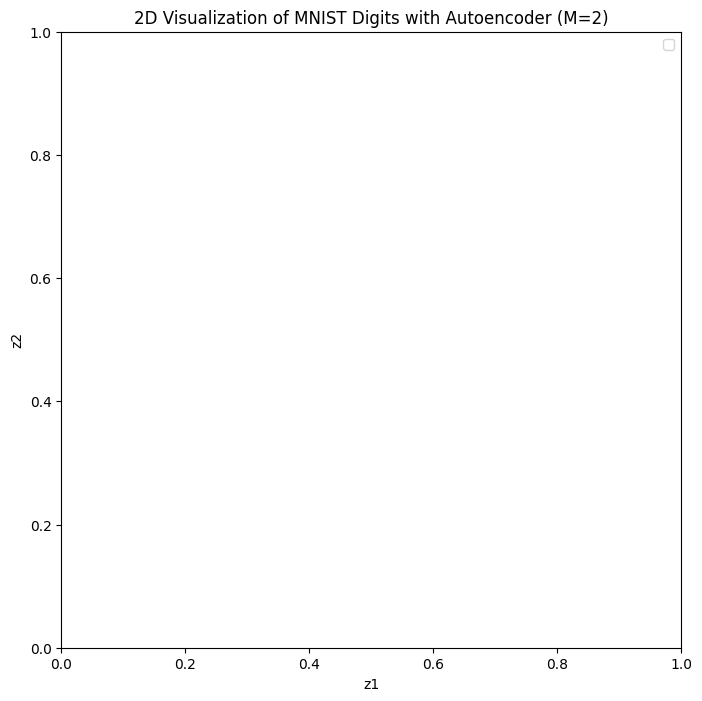

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# Ensure selected_samples has 100 samples each for digits 0, 1, and 9
selected_samples = {0: [], 1: [], 9: []}

# Iterate through the test dataset and select samples
for data, target in test_dataset:
    if target in selected_samples:  # Only process labels 0, 1, 9
        if len(selected_samples[target]) < 100:
            selected_samples[target].append(data.view(-1, 784))  # Flatten the image
    if all(len(selected_samples[d]) == 100 for d in [0, 1, 9]):
        break

# Encode the samples and plot the 2D latent variables
model.eval()
with torch.no_grad():
    plt.figure(figsize=(8, 8))
    colors = ['blue', 'green', 'red']
    labels = [0, 1, 9]

    for idx, label in enumerate(labels):
        # Stack the selected samples for each label
        data_tensor = torch.stack(selected_samples[label]).to(device)

        # Pass data through the encoder to get the latent variable z (ensure M=2)
        z = model.encoder(data_tensor).cpu().numpy()

        # Ensure that the output of the encoder is 2D (M=2), then plot
        if z.shape[1] == 2:  # Check if there are two components in the latent space
            plt.scatter(z[:, 0], z[:, 1], c=colors[idx], label=f"Digit {label}", alpha=0.6)
        else:
            print(f"Encoder output for label {label} does not have two components.")

    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.legend()
    plt.title("2D Visualization of MNIST Digits with Autoencoder (M=2)")
    plt.show()
